Carlos Carrasco, UC Davis, Python Development of SVM routines to perform single trial decoding with EEG data for the Meta project, 2023. 
cdcarrasco@ucdavis.edu

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
#Functions for main analysis 

def DataParser(EEGData, time):
    Correct = EEGData["binorgEEG"]["binwise_data"][0][0][0][0][0]
    Incorrect = EEGData["binorgEEG"]["binwise_data"][0][0][0][1][0]
    
    # Slice the data based on TimeWindow
    sliced_corr_array = np.delete(Correct, [15, 19], axis=0)
    sliced_corr_array = sliced_corr_array[:, time, 0:36]
    
    sliced_incorr_array = np.delete(Incorrect, [15, 19], axis=0)
    sliced_incorr_array = sliced_incorr_array[:, time, 0:36]
    
    return sliced_corr_array, sliced_incorr_array

def DataParser_TW(EEGData, start,end):
    Correct = EEGData["binorgEEG"]["binwise_data"][0][0][0][0][0]
    Incorrect = EEGData["binorgEEG"]["binwise_data"][0][0][0][1][0]
    
    # Slice the data based on TimeWindow
    sliced_corr_array = np.delete(Correct, [15, 19], axis=0)
    sliced_corr_array = sliced_corr_array[:, start:end, 0:36]
    sliced_corr_array = np.mean(sliced_corr_array, axis=1)
    
    sliced_incorr_array = np.delete(Incorrect, [15, 19], axis=0)
    sliced_incorr_array = sliced_incorr_array[:, start:end, 0:36]
    sliced_incorr_array = np.mean(sliced_incorr_array, axis=1)
    
    return sliced_corr_array, sliced_incorr_array

def DataParser_3d(EEGData,start,end):
    Correct = EEGData["binorgEEG"]["binwise_data"][0][0][0][0][0]
    Incorrect = EEGData["binorgEEG"]["binwise_data"][0][0][0][1][0]
    
    # Slice the data based on TimeWindow
    sliced_corr_array = np.delete(Correct, [15, 19], axis=0)
    sliced_corr_array = sliced_corr_array[:, start:end, 0:36]
    sliced_corr_array = sliced_corr_array.reshape(-1, sliced_corr_array.shape[-1])

    
    sliced_incorr_array = np.delete(Incorrect, [15, 19], axis=0)
    sliced_incorr_array = sliced_incorr_array[:, start:end, 0:36]
    sliced_incorr_array = sliced_incorr_array.reshape(-1, sliced_incorr_array.shape[-1])
    #sliced_incorr_array = sliced_incorr_array.reshape(sliced_incorr_array.shape[0], -1)
    
    return sliced_corr_array, sliced_incorr_array


def Classification_Routine(collapsed_corr_array,collapsed_incorr_array,kerneltype):
    
    X = np.concatenate((collapsed_corr_array, collapsed_incorr_array), axis=1).T
    Y =  np.concatenate((np.zeros(collapsed_corr_array.shape[1]), np.ones(collapsed_incorr_array.shape[1])))
    # Reshape it to be 1D (if needed)
    Y = Y.reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)
    classifier = SVC(kernel = kerneltype, random_state = 222)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test,y_pred)

    return cm, acc

def plot_time_series(all_acc,title):
    # Calculate the mean and standard error
    mean_data = np.mean(all_acc, axis=0)
    std_error = np.std(all_acc, axis=0) / np.sqrt(all_acc.shape[0])

    # List of custom tick positions and labels (replace with your own)
    custom_ticks = [0, 125, 250, 375, 500, 625]
    custom_labels = ['-500', '0', '500', '1000', '1500', '2000']

    # Create the plot with standard error shading
    plt.figure(figsize=(4, 2))
    plt.plot(mean_data, label='Mean', color='b')
    plt.fill_between(np.arange(len(mean_data)), mean_data - std_error, mean_data + std_error, alpha=0.2, color='b', label='Standard Error')

    # Set custom ticks and labels
    plt.xticks(custom_ticks, custom_labels)
    # Add vertical line at x=0 and horizontal line at y=0.5
    plt.axvline(x=125, color='black', linestyle='--')
    plt.axvline(x=250, color='black', linestyle='--')
    plt.axhline(y=0.5, color='black', linestyle='--')

    # Set custom x and y limits
    plt.xlim(0, len(mean_data))  # Adjust the x-axis limits as needed
    plt.ylim(0.4, .9)  # Adjust the y-axis limits as needed

    # Add labels and legend
    plt.xlabel('Time (ms)')
    plt.ylabel('Decoding Accuracy')
    plt.title(title)
    plt.show() 




def plot_confusion(all_cm,timestart,time_end):
    #Plotting CM at timewindow of interest 250 - 500 ms (Linear SVM)
    mean_cm = np.mean(all_cm, axis=0)
    mean_cm_tw = np.mean(mean_cm[timestart:time_end,:,:], axis=0)
    result_array = (mean_cm_tw / 9) * 100

    # Create a heatmap
    plt.figure(figsize=(4, 2))
    plt.imshow(result_array, cmap='viridis', interpolation='nearest')

    # Add a colorbar for reference
    plt.colorbar()

    # Add labels for TP, FP, FN, TN
    for i in range(2):
        for j in range(2):
            if i == 0 and j == 0:
                plt.text(j, i, 'TP', va='center', ha='center', color='k', fontsize=12)
            elif i == 0 and j == 1:
                plt.text(j, i, 'FP', va='center', ha='center', color='k', fontsize=12)
            elif i == 1 and j == 0:
                plt.text(j, i, 'FN', va='center', ha='center', color='k', fontsize=12)
            elif i == 1 and j == 1:
                plt.text(j, i, 'TN', va='center', ha='center', color='k', fontsize=12)

    # Show the plot
    plt.show()
    print(result_array)




Implementing Time point by timepoint decoding for subjects to gain insight into where we have the most signal using an SVM with a sigmoid kernel

In [26]:
#Sub Loop to do timepoint by timepoint decoding 
subs = [1, 2, 3]
time_data = sio.loadmat('time.mat')
time = time_data["time"]
time = time.reshape(-1)

# Initialize lists to store results for each subject
all_cm = []
all_acc = []

for sub in subs:
    file_name = f"EEG_Theta_BE_{sub}.mat"
    EEGData = sio.loadmat(file_name)
    
    # Initialize lists to store results for each time window for the current subject
    subject_cm = []
    subject_acc = []
    
    for t in range(0, len(time)):

        
        sliced_corr_array, sliced_incorr_array = DataParser(EEGData, t)
        
        # Perform classification and obtain cm and acc
        cm, acc = Classification_Routine(sliced_corr_array, sliced_incorr_array,'sigmoid')
        
        # Append cm and acc to subject-specific lists
        subject_cm.append(cm)
        subject_acc.append(acc)
    
    # Append subject-specific lists to the overall lists
    all_cm.append(subject_cm)
    all_acc.append(subject_acc)

# Convert the lists to NumPy arrays for further analysis if needed
all_cm = np.array(all_cm)
all_acc = np.array(all_acc)


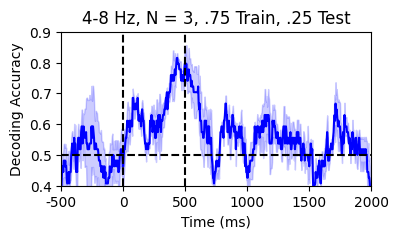

In [7]:
plot_time_series(all_acc,'4-8 Hz, N = 3, .75 Train, .25 Test')


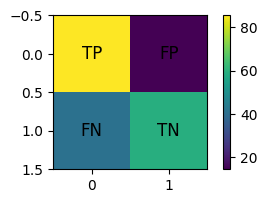

[[85.48148148 14.51851852]
 [41.03703704 58.96296296]]


In [28]:
#Plotting CM at timewindow of interest 250 - 500 ms 
plot_confusion(all_cm,200,250)

What we're doing here is taking the 300:500 ms time window and collapsing that into the channels dimension. This allows us to have more features in the SVM and why I call it 3D. 

In [21]:
#Sub Loop to do timepoint by timepoint decoding 
subs = [1, 2, 3]
time_data = sio.loadmat('time.mat')
time = time_data["time"]
time = time.reshape(-1)

# Initialize lists to store results for each subject
all_cm = []
all_acc = []


for sub in subs:
    file_name = f"EEG_Theta_BE_{sub}.mat"
    EEGData = sio.loadmat(file_name)
    
    # Initialize lists to store results for each time window for the current subject
    subject_cm = []
    subject_acc = []
    
    for t in range(0, 1):

        
        sliced_corr_array, sliced_incorr_array = DataParser_3d(EEGData, 200,250)
        
        # Perform classification and obtain cm and acc
        cm, acc = Classification_Routine(sliced_corr_array, sliced_incorr_array,'sigmoid')
        
        # Append cm and acc to subject-specific lists
        subject_cm.append(cm)
        subject_acc.append(acc)
    
    # Append subject-specific lists to the overall lists
    all_cm.append(subject_cm)
    all_acc.append(subject_acc)

# Convert the lists to NumPy arrays for further analysis if needed
all_cm = np.array(all_cm)
all_acc = np.array(all_acc)


[0.77777778]


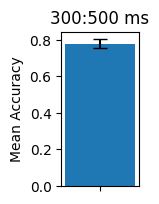

In [22]:
mean_acc = np.mean(all_acc,axis =0)
mean_se = np.std(all_acc, axis=0) / np.sqrt(all_acc.shape[0])
# x-axis labels (replace with your labels)
labels = ['']
plt.figure(figsize=(1, 2))
# Create a bar plot
plt.bar(labels, mean_acc, yerr=mean_se, capsize=5)  # 'yerr' specifies the standard error

# Add labels and title
plt.xlabel('')
plt.ylabel('Mean Accuracy')
plt.title('300:500 ms')
print(mean_acc)

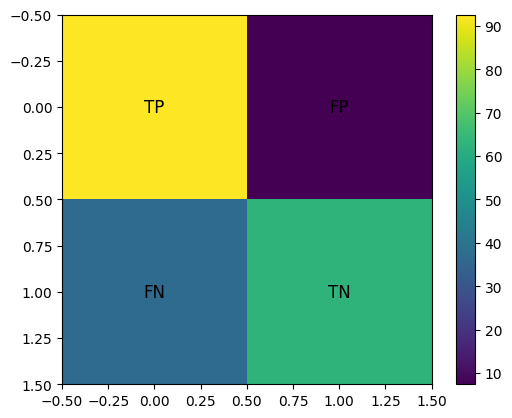

[[92.59259259  7.40740741]
 [37.03703704 62.96296296]]


In [23]:
#Plotting CM at timewindow of interest 250 - 500 ms (Linear SVM)
mean_cm = np.mean(all_cm, axis=0)
mean_cm_tw = np.mean(mean_cm[:,:,:], axis=0)
result_array = (mean_cm_tw)/9 * 100

    # Create a heatmap
    # plt.figure(figsize=(4, 2))
plt.imshow(result_array, cmap='viridis', interpolation='nearest')

    # Add a colorbar for reference
plt.colorbar()

    # Add labels for TP, FP, FN, TN
for i in range(2):
     for j in range(2):
        if i == 0 and j == 0:
            plt.text(j, i, 'TP', va='center', ha='center', color='k', fontsize=12)
        elif i == 0 and j == 1:
            plt.text(j, i, 'FP', va='center', ha='center', color='k', fontsize=12)
        elif i == 1 and j == 0:
             plt.text(j, i, 'FN', va='center', ha='center', color='k', fontsize=12)
        elif i == 1 and j == 1:
            plt.text(j, i, 'TN', va='center', ha='center', color='k', fontsize=12)

# Show the plot
plt.show()
print(result_array)

In [24]:
print((all_cm/9))


[[[[0.77777778 0.22222222]
   [0.11111111 0.88888889]]]


 [[[1.         0.        ]
   [0.44444444 0.55555556]]]


 [[[1.         0.        ]
   [0.55555556 0.44444444]]]]
